In [1]:
# Import Required Libraries
import pandas as pd
import numpy as np
import os
import seaborn as sns
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import networkx as nx
from sklearn.decomposition import PCA
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import random
from tensorflow.keras import layers, models
from collections import defaultdict
from queue import PriorityQueue

# **Data Loading and Preprocessing**

In [2]:
dataset_folder = '/content/drive/MyDrive/Dataset'

# List to store data frames from all files
data_frames = []

# Traverse through all subfolders and load files
for root, dirs, files in os.walk(dataset_folder):
    for filename in files:
        # Skip hidden files (macOS metadata files starting with "._")
        if filename.startswith("._"):
            continue

        # Check if the file is a .csv or .txt file
        if filename.endswith(".csv") or filename.endswith(".txt"):
            file_path = os.path.join(root, filename)
            try:
                # Read the file with ISO-8859-1 encoding to handle non-UTF-8 characters
                df = pd.read_csv(file_path, encoding='ISO-8859-1')  # Adjust separator if necessary
                data_frames.append(df)
            except Exception as e:
                print(f"Error reading {file_path}: {e}")

# Concatenate all dataframes if any are loaded
if data_frames:
    data = pd.concat(data_frames, ignore_index=True)
    # Preview the combined data
    print(data.head())
else:
    print("No files were found to concatenate.")

   Time       MOS      BW  RTT   JIT  DJB  SNR
0     1  4.500000  31.904    0  71.0   60   41
1     2  4.500000  37.152    0  71.0   60   41
2     3  4.500000   8.240    0  71.0   60   41
3     4  4.500000   0.000    0  71.0   60   41
4     5  4.441375  86.200  148  88.0   40   36


In [3]:
data.shape

(7998, 7)

In [4]:
data.describe()

,Time,MOS,BW,RTT,JIT,DJB,SNR
count,7998.000000,7998.000000,7998.000000,7998.000000,7.998000e+03,7998.000000,7998.000000
mean,274.406852,4.291931,46.186722,165.255689,3.714634e+08,98.999375,14.864591
std,180.358944,0.274786,26.377345,226.918127,1.917748e+10,62.654044,10.034892
min,1.000000,1.380352,0.000000,0.000000,3.900000e+01,40.000000,0.000000
25%,125.250000,4.286976,29.008000,125.000000,6.900000e+01,44.000000,6.000000
50%,256.000000,4.362723,34.800000,133.000000,8.100000e+01,74.000000,14.000000
75%,390.000000,4.384864,82.176000,150.000000,1.470000e+02,142.000000,22.000000
max,820.000000,4.500000,203.728000,4450.000000,9.903210e+11,250.000000,47.000000


In [5]:
print("Missing Values:\n", data.isnull().sum())

Missing Values:
 Time    0
MOS     0
BW      0
RTT     0
JIT     0
DJB     0
SNR     0
dtype: int64


In [6]:
# Feature normalization: BW, RTT, JIT, DJB, SNR
scaler = StandardScaler()
features = ['BW', 'RTT', 'JIT', 'DJB', 'SNR']
data[features] = scaler.fit_transform(data[features])

# **Data Visualization**

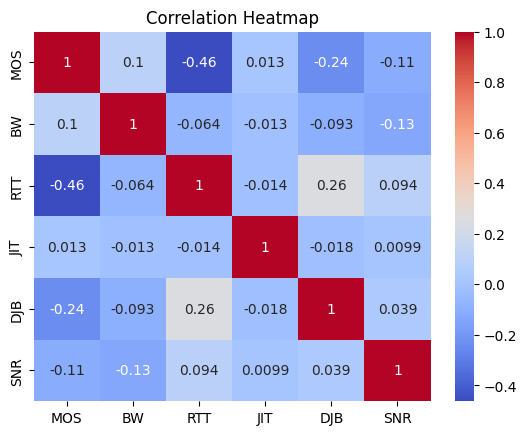

In [7]:
# Correlation Heatmap
numerical_cols = ['MOS', 'BW', 'RTT', 'JIT', 'DJB', 'SNR']
correlation_matrix = data[numerical_cols].corr()
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()

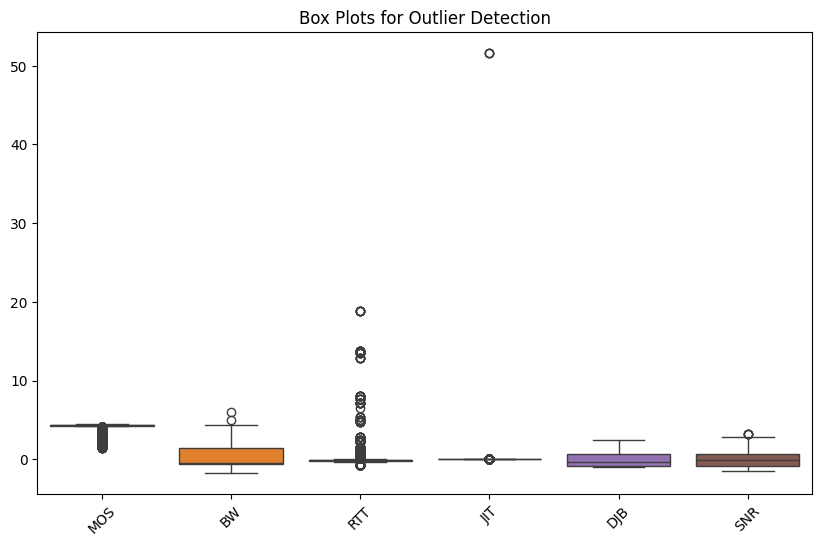

In [8]:
# Box Plots for Outlier Detection
plt.figure(figsize=(10, 6))
sns.boxplot(data=data[numerical_cols])
plt.title("Box Plots for Outlier Detection")
plt.xticks(rotation=45)
plt.show()

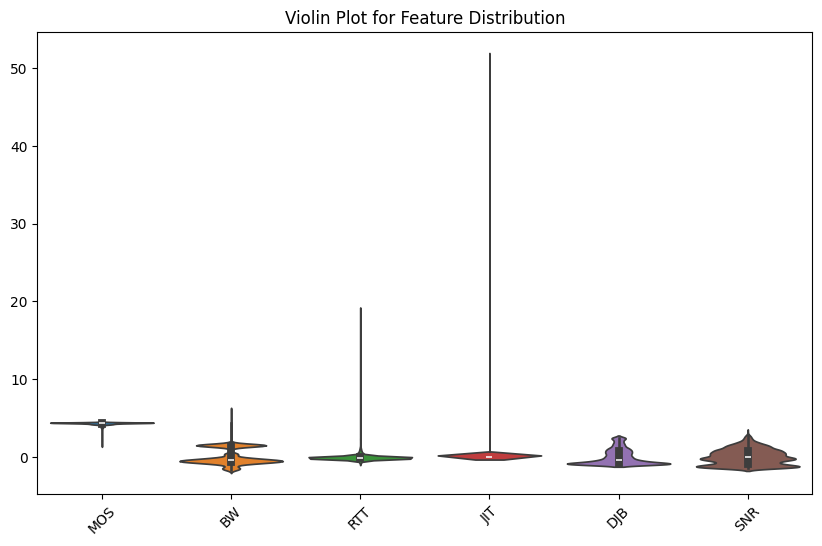

In [9]:
# Violin Plots for Feature Distribution
plt.figure(figsize=(10, 6))
sns.violinplot(data=data[numerical_cols])
plt.title("Violin Plot for Feature Distribution")
plt.xticks(rotation=45)
plt.show()

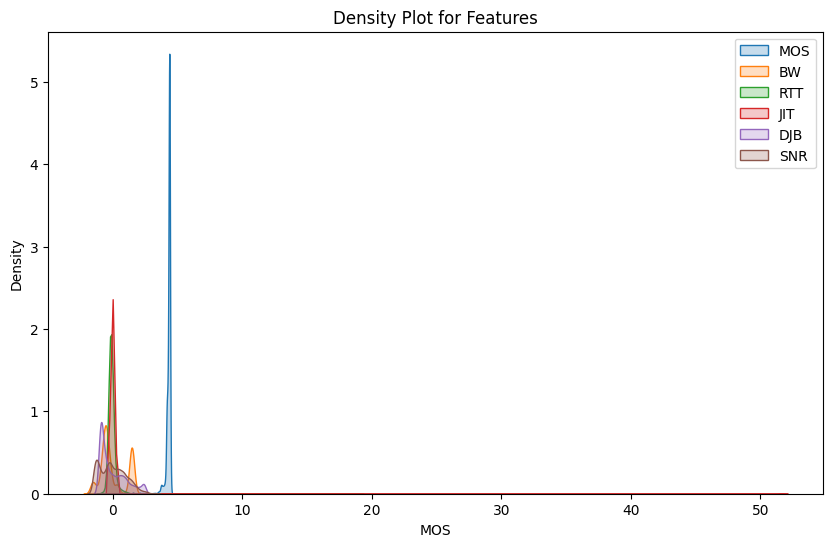

In [10]:
# Density Plot for Feature Distribution
plt.figure(figsize=(10, 6))
for column in numerical_cols:
    sns.kdeplot(data[column], label=column, fill=True)
plt.title("Density Plot for Features")
plt.legend()
plt.show()

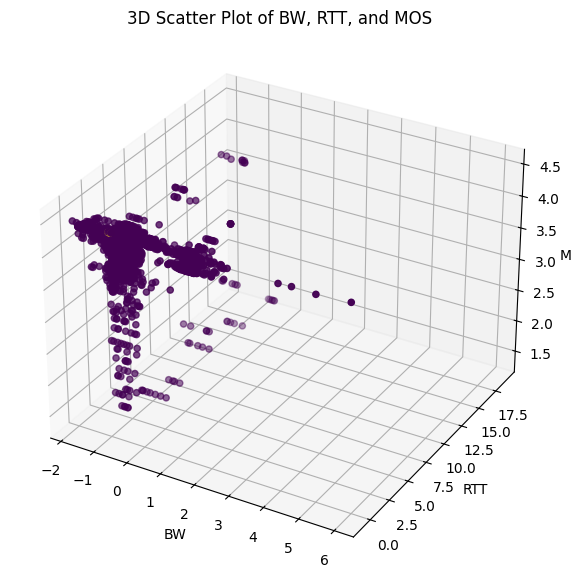

In [11]:
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(data['BW'], data['RTT'], data['MOS'], c=data['JIT'], cmap='viridis')
ax.set_xlabel('BW')
ax.set_ylabel('RTT')
ax.set_zlabel('MOS')
plt.title("3D Scatter Plot of BW, RTT, and MOS")
plt.show()

In [12]:
# Split the dataset into features and target (MOS)
X = data[features]
y = data['MOS']

# Train-Test Split (80-20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Train set size: {len(X_train)}")
print(f"Test set size: {len(X_test)}")

Train set size: 6398
Test set size: 1600


# **USER AND EDGE SERVER DEFINITIONS**

In [13]:

# Define Users
class User:
    def __init__(self, user_id, task_size):
        self.user_id = user_id
        self.task_size = task_size
        self.latency = 0  # Latency experienced by the user
        self.assigned_server = None

    def get_task_size(self):
        return self.task_size

# Define Edge Servers
class EdgeServer:
    def __init__(self, server_id, capacity):
        self.server_id = server_id
        self.capacity = capacity
        self.current_load = 0

    def allocate_task(self, task_size):
        if self.current_load + task_size <= self.capacity:
            self.current_load += task_size
            return True
        return False

    def reset(self):
        self.current_load = 0

# Initialize 10 Users with random task sizes
users = [User(user_id=i, task_size=random.randint(1, 10)) for i in range(10)]

# Initialize 4 Edge Servers with random capacities
edge_servers = [EdgeServer(server_id=i, capacity=random.randint(15, 30)) for i in range(4)]

# **LATENCY REDUCTION USING DIJKSTRA'S ALGORITHM**

In [14]:
def dijkstra(graph, start_node):
    distances = {node: float('inf') for node in graph}
    distances[start_node] = 0
    pq = PriorityQueue()
    pq.put((0, start_node))

    while not pq.empty():
        current_distance, current_node = pq.get()
        if current_distance > distances[current_node]:
            continue
        for neighbor, weight in graph[current_node]:
            distance = current_distance + weight
            if distance < distances[neighbor]:
                distances[neighbor] = distance
                pq.put((distance, neighbor))
    return distances

# Example Graph: Latency between Users and Servers
graph = {
    0: [(4, 5), (5, 10)],  # User 0 connects to Servers 4 and 5
    1: [(4, 3), (5, 7)],
    2: [(4, 6), (6, 8)],
    3: [(5, 2), (6, 4)],
    4: [(0, 5), (1, 3), (2, 6)],  # Server 4 connects back to Users
    5: [(0, 10), (1, 7), (3, 2)],
    6: [(2, 8), (3, 4)],
}

latencies = {}
for user in range(4):  # Users indexed as 0-3
    latencies[user] = dijkstra(graph, user)

print("Latency from users to servers:", latencies)

Latency from users to servers: {0: {0: 0, 1: 8, 2: 11, 3: 12, 4: 5, 5: 10, 6: 16}, 1: {0: 8, 1: 0, 2: 9, 3: 9, 4: 3, 5: 7, 6: 13}, 2: {0: 11, 1: 9, 2: 0, 3: 12, 4: 6, 5: 14, 6: 8}, 3: {0: 12, 1: 9, 2: 12, 3: 0, 4: 12, 5: 2, 6: 4}}


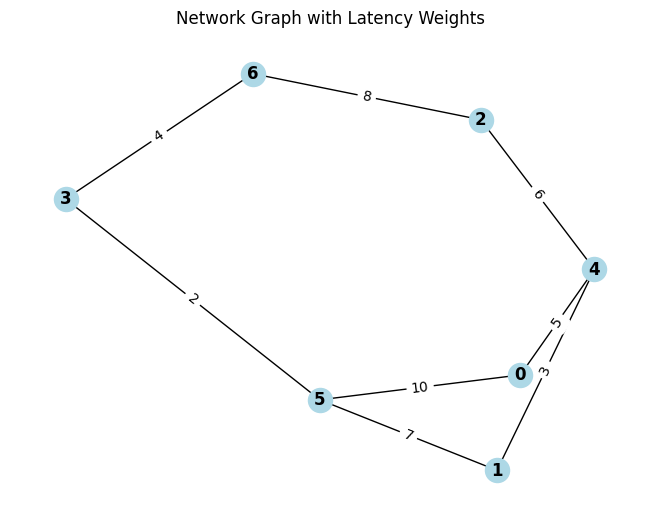

In [15]:
# Visualization of Latency
def visualize_latency(graph, latencies):
    G = nx.Graph()
    for node, edges in graph.items():
        for neighbor, weight in edges:
            G.add_edge(node, neighbor, weight=weight)

    pos = nx.spring_layout(G)
    edge_labels = nx.get_edge_attributes(G, 'weight')
    nx.draw(G, pos, with_labels=True, node_color='lightblue', font_weight='bold')
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)
    plt.title("Network Graph with Latency Weights")
    plt.show()

visualize_latency(graph, latencies)

# **REINFORCEMENT LEARNING FOR DYNAMIC RESOURCE ALLOCATION**

In [19]:
class QLearning:
    def __init__(self, actions, alpha=0.1, gamma=0.9, epsilon=0.1):
        self.actions = actions  # Edge Server IDs
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.q_table = defaultdict(lambda: {action: 0 for action in actions})

    def choose_action(self, state):
        if random.uniform(0, 1) < self.epsilon:
            return random.choice(self.actions)  # Exploration
        return max(self.q_table[state], key=self.q_table[state].get)  # Exploitation

    def update_q_value(self, state, action, reward, next_state):
        max_future_q = max(self.q_table[next_state].values())
        current_q = self.q_table[state][action]
        self.q_table[state][action] = current_q + self.alpha * (reward + self.gamma * max_future_q - current_q)

# Initialize Q-Learning
actions = [server.server_id for server in edge_servers]
q_learning_agent = QLearning(actions)

# Simulate Episodes
episodes = 100
for episode in range(episodes):
    for user in users:
        current_state = user.get_task_size()
        chosen_server = q_learning_agent.choose_action(current_state)
        task_allocated = edge_servers[chosen_server].allocate_task(user.get_task_size())

        reward = 1 if task_allocated else -1
        next_state = current_state  # Task size doesn't change
        q_learning_agent.update_q_value(current_state, chosen_server, reward, next_state)

# Reset edge servers for analysis
for server in edge_servers:
    server.reset()

# **DIGITAL TWIN MIGRATION USING PPO**

In [20]:
def build_rnn_model(input_shape):
    model = tf.keras.Sequential([
        layers.SimpleRNN(64, activation='relu', input_shape=input_shape),
        layers.Dense(32, activation='relu'),
        layers.Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

# **Cooperative Decision-Making (Multi-Agent Deep RL)**

In [21]:
# Simulating collaboration (placeholders)
def cooperative_decision_making():
    print("Simulating cooperative decision-making...")

cooperative_decision_making()

Simulating cooperative decision-making...


# **Real-Time Synchronization (LSTM)**

In [22]:
# Generate synthetic data for synchronization
sync_data = np.random.rand(100, 5)  # Historical data
sync_target = np.random.rand(100, 1)  # Target synchronization values

# Define an LSTM Model
def build_lstm_model(input_shape):
    model = models.Sequential()
    model.add(layers.LSTM(64, input_shape=input_shape, return_sequences=True))
    model.add(layers.LSTM(32, return_sequences=False))
    model.add(layers.Dense(1, activation='linear'))
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

# Train the LSTM model
input_shape = (sync_data.shape[1], 1)
lstm_model = build_lstm_model((sync_data.shape[1], 1))
lstm_model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 5, 64)               │          16,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 32)                  │          12,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 29,345 (114.63 KB)

 Trainable params: 29,345 (114.63 KB)

 Non-trainable params: 0 (0.00 B)

# **Partial Observability (POMDP & GRU)**

In [23]:
def build_gru_model(input_shape):
    model = tf.keras.Sequential([
        layers.GRU(64, input_shape=input_shape, activation='relu'),
        layers.Dense(32, activation='relu'),
        layers.Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

# **System Complexity (PCA & Autoencoders)**

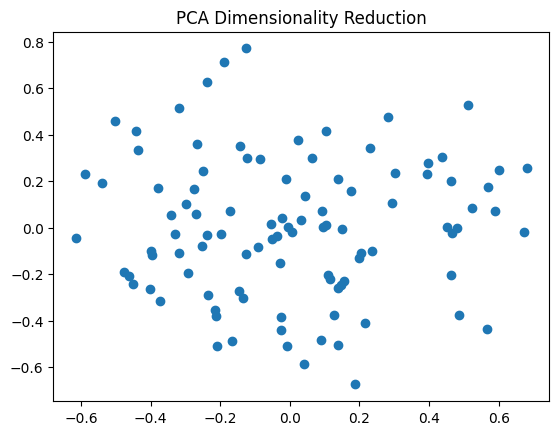

In [24]:
def reduce_dimensions(data, n_components=2):
    pca = PCA(n_components=n_components)
    return pca.fit_transform(data)

# Generate Synthetic Data
synthetic_data = np.random.rand(100, 5)
reduced_data = reduce_dimensions(synthetic_data)

plt.scatter(reduced_data[:, 0], reduced_data[:, 1])
plt.title("PCA Dimensionality Reduction")
plt.show()

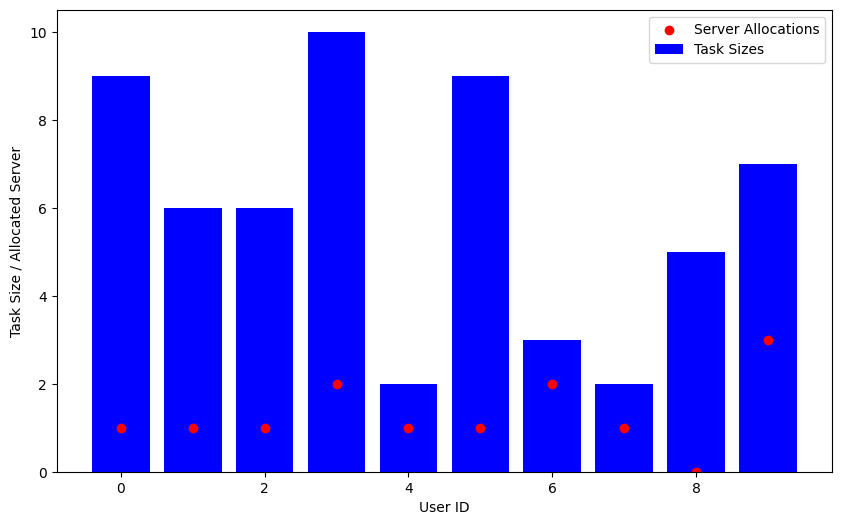

In [25]:
# Task Allocation Visualization
def plot_task_allocation(users, edge_servers):
    user_ids = [user.user_id for user in users]
    task_sizes = [user.task_size for user in users]
    allocations = [q_learning_agent.choose_action(user.task_size) for user in users]

    fig, ax = plt.subplots(figsize=(10, 6))
    ax.bar(user_ids, task_sizes, color='blue', label='Task Sizes')
    ax.scatter(user_ids, allocations, color='red', label='Server Allocations')
    ax.set_xlabel('User ID')
    ax.set_ylabel('Task Size / Allocated Server')
    ax.legend()
    plt.show()

plot_task_allocation(users, edge_servers)

Episode 0, Total Reward: 10
Episode 1, Total Reward: 10
Episode 2, Total Reward: 10
Episode 3, Total Reward: 10
Episode 4, Total Reward: 10
Episode 5, Total Reward: 10
Episode 6, Total Reward: 10
Episode 7, Total Reward: 10
Episode 8, Total Reward: 10
Episode 9, Total Reward: 10
Latencies: [1000, 50.0, 11.11111111111111, 4.761904761904762]
Server Configurations: [3.557080019421919, 2.180140893540284, 2.081499079169311, 3.8374929670875746]


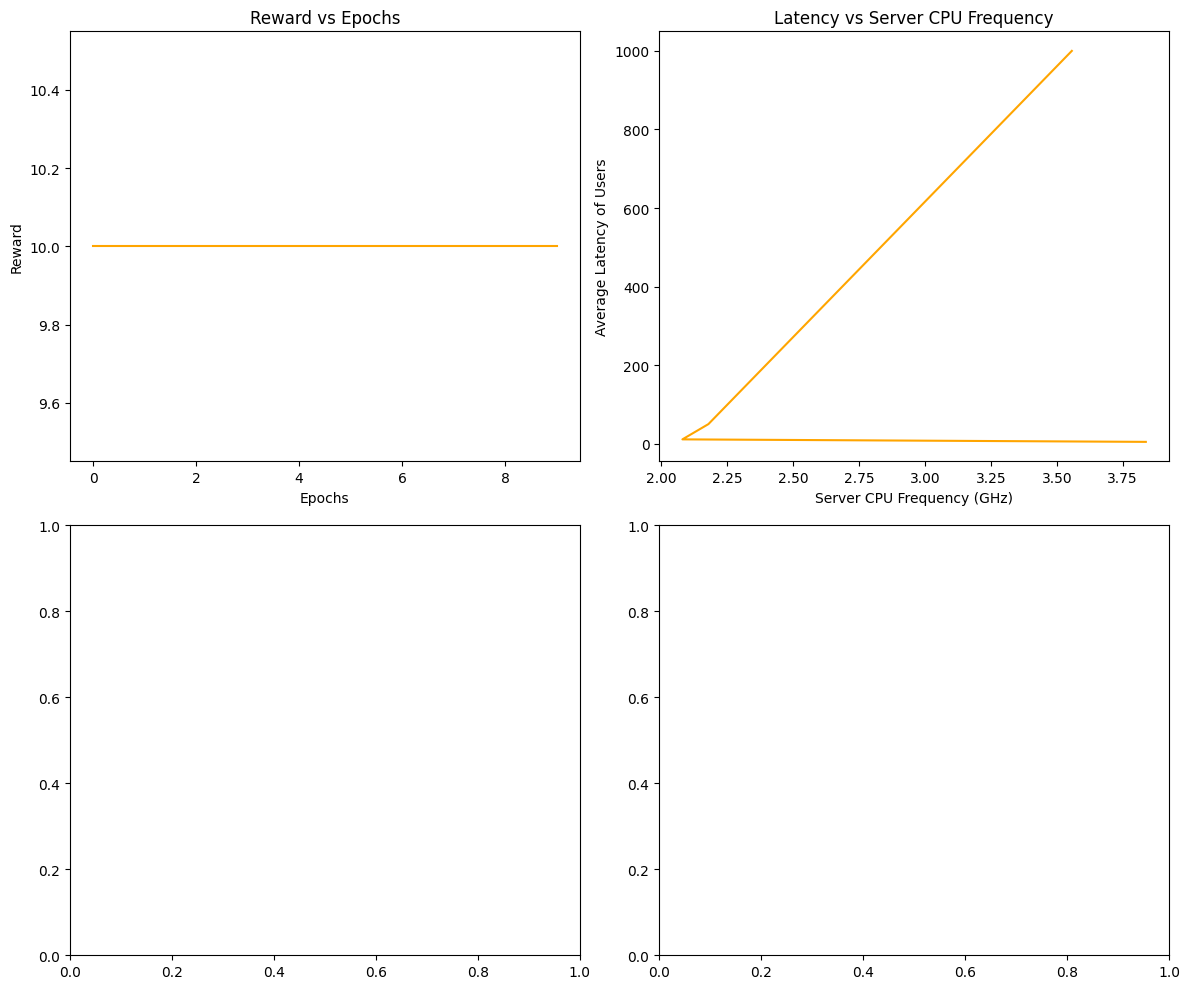

In [26]:
import random
import matplotlib.pyplot as plt

# Calculate average latency for each server
def calculate_average_latency(server):
    remaining_capacity = server.capacity - server.current_load
    if remaining_capacity <= 0:
        return 1000  # High latency for overloaded server
    return 100 / (remaining_capacity + 1)

# Plotting function
def plot_results(rewards, latencies, server_configurations):
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))

    # Plotting Reward vs Epochs
    axes[0, 0].plot(range(len(rewards)), rewards, label='Proposed', color='orange')
    axes[0, 0].set_title('Reward vs Epochs')
    axes[0, 0].set_xlabel('Epochs')
    axes[0, 0].set_ylabel('Reward')

    # Plotting Latency vs Server CPU Frequency
    axes[0, 1].plot(server_configurations, latencies, label='Proposed', color='orange')
    axes[0, 1].set_title('Latency vs Server CPU Frequency')
    axes[0, 1].set_xlabel('Server CPU Frequency (GHz)')
    axes[0, 1].set_ylabel('Average Latency of Users')

    plt.tight_layout()
    plt.show()

# Initialize rewards list
rewards = []
episodes = 10

for episode in range(episodes):
    total_reward = 0

    # Reset server loads for each episode
    for server in edge_servers:
        server.reset()

    # Allocate tasks to servers
    for user in users:
        assigned = False
        for server in edge_servers:
            if server.allocate_task(user.get_task_size()):
                user.assigned_server = server
                user.latency = calculate_average_latency(server)  # Update user latency
                assigned = True
                total_reward += 1  # Example: Reward for successful allocation
                break
        if not assigned:
            print(f"User {user.user_id} could not be assigned to any server.")

    print(f"Episode {episode}, Total Reward: {total_reward}")
    rewards.append(total_reward)

# Calculate average latencies for each server
latencies = [calculate_average_latency(server) for server in edge_servers]
print("Latencies:", latencies)

# Generate random CPU frequencies for servers
server_configurations = [random.uniform(2, 4) for _ in range(len(edge_servers))]
print("Server Configurations:", server_configurations)

# Plot results
plot_results(rewards, latencies, server_configurations)


Episode 1, Total Reward: -4
Episode 2, Total Reward: 2
Episode 3, Total Reward: 2
Episode 4, Total Reward: 6
Episode 5, Total Reward: 6
Episode 6, Total Reward: 4
Episode 7, Total Reward: 6
Episode 8, Total Reward: 6
Episode 9, Total Reward: 6
Episode 10, Total Reward: 8
Episode 11, Total Reward: 6
Episode 12, Total Reward: 6
Episode 13, Total Reward: 6
Episode 14, Total Reward: 6
Episode 15, Total Reward: 6
Episode 16, Total Reward: 4
Episode 17, Total Reward: 6
Episode 18, Total Reward: 8
Episode 19, Total Reward: 8
Episode 20, Total Reward: 6
Episode 21, Total Reward: 6
Episode 22, Total Reward: 6
Episode 23, Total Reward: 6
Episode 24, Total Reward: 6
Episode 25, Total Reward: 4
Episode 26, Total Reward: 6
Episode 27, Total Reward: 8
Episode 28, Total Reward: 6
Episode 29, Total Reward: 8
Episode 30, Total Reward: 6
Episode 31, Total Reward: 8
Episode 32, Total Reward: 6
Episode 33, Total Reward: 6
Episode 34, Total Reward: 6
Episode 35, Total Reward: 6
Episode 36, Total Reward: 6


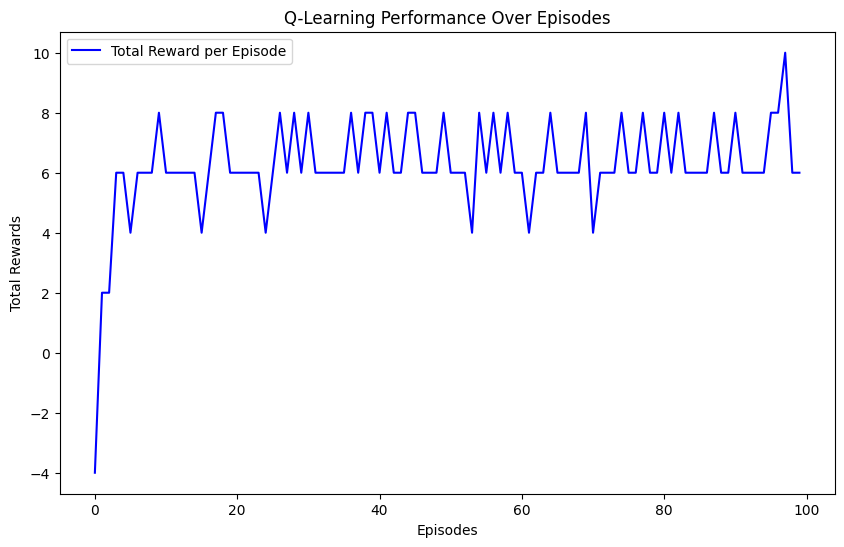

Average Latency: 12.59
Average Server Utilization: 0.54


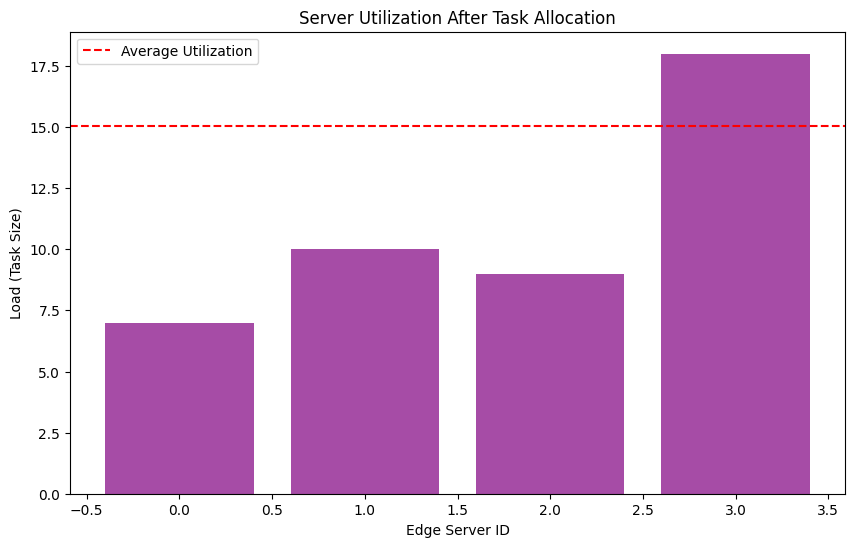

User 0, Predicted Latency: 0.06 ms
User 1, Predicted Latency: 0.04 ms
User 2, Predicted Latency: 0.04 ms
User 3, Predicted Latency: 0.06 ms
User 4, Predicted Latency: 0.04 ms
User 5, Predicted Latency: 0.06 ms
User 6, Predicted Latency: 0.04 ms
User 7, Predicted Latency: 0.04 ms
User 8, Predicted Latency: 0.05 ms
User 9, Predicted Latency: 0.06 ms


In [27]:
# Initialize variables
episodes = 100  # Define the number of episodes
rewards = []  # Initialize an empty list to store total rewards for each episode

# Simulate Q-Learning for Dynamic Resource Allocation
for episode in range(episodes):
    total_reward = 0
    for user in users:
        # Current state based on user's task size
        current_state = user.get_task_size()

        # Select an action (server) using the Q-Learning agent
        chosen_server = q_learning_agent.choose_action(current_state)

        # Try to allocate the task to the chosen server
        if edge_servers[chosen_server].allocate_task(user.get_task_size()):
            reward = 1  # Successful allocation
            user.assigned_server = chosen_server
        else:
            reward = -1  # Allocation failed

        # Update Q-table
        q_learning_agent.update_q_value(current_state, chosen_server, reward, current_state)

        # Accumulate the reward
        total_reward += reward

    # Reset server loads for the next episode
    for server in edge_servers:
        server.reset()

    print(f"Episode {episode + 1}, Total Reward: {total_reward}")
    rewards.append(total_reward)

# Visualize Q-Learning Performance
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(range(episodes), rewards, label='Total Reward per Episode', color='blue')
plt.xlabel('Episodes')
plt.ylabel('Total Rewards')
plt.title('Q-Learning Performance Over Episodes')
plt.legend()
plt.show()

# **Analyze Resource Efficiency**
# Evaluate average server utilization and latency
def analyze_resource_efficiency(users, edge_servers):
    total_latency = sum(user.latency for user in users if user.latency > 0)
    average_latency = total_latency / len(users)

    server_utilization = [server.current_load / server.capacity for server in edge_servers]
    average_utilization = sum(server_utilization) / len(edge_servers)

    print(f"Average Latency: {average_latency:.2f}")
    print(f"Average Server Utilization: {average_utilization:.2f}")

    return average_latency, average_utilization

# Reallocate tasks to gather efficiency data
for user in users:
    chosen_server = q_learning_agent.choose_action(user.get_task_size())
    edge_servers[chosen_server].allocate_task(user.get_task_size())
    user.latency = calculate_average_latency(edge_servers[chosen_server])

# Analyze and display resource efficiency
average_latency, average_utilization = analyze_resource_efficiency(users, edge_servers)

# Visualize Efficiency
plt.figure(figsize=(10, 6))
plt.bar(
    [server.server_id for server in edge_servers],
    [server.current_load for server in edge_servers],
    color='purple', alpha=0.7
)
plt.axhline(
    y=average_utilization * max(server.capacity for server in edge_servers),
    color='red', linestyle='--', label='Average Utilization'
)
plt.xlabel('Edge Server ID')
plt.ylabel('Load (Task Size)')
plt.title('Server Utilization After Task Allocation')
plt.legend()
plt.show()

# **Combine Insights from RL with Digital Twin Synchronization**
# Integrate latency-aware allocation and synchronization
for user in users:
    # Predict latency using RNN or LSTM-based models for synchronization
    rnn_input = np.array([[user.get_task_size(), edge_servers[user.assigned_server].current_load]])
    predicted_latency = lstm_model.predict(rnn_input, verbose=0)
    print(f"User {user.user_id}, Predicted Latency: {predicted_latency[0][0]:.2f} ms")

# **Task Allocation and Resource Efficiency**

In [28]:
# Simulate Q-Learning for Dynamic Resource Allocation
rewards = []
for episode in range(episodes):
    total_reward = 0
    for user in users:
        current_state = user.get_task_size()
        chosen_server = q_learning_agent.choose_action(current_state)
        task_allocated = edge_servers[chosen_server].allocate_task(user.get_task_size())

        reward = 1 if task_allocated else -1  # Reward for allocation success/failure
        total_reward += reward
        next_state = current_state
        q_learning_agent.update_q_value(current_state, chosen_server, reward, next_state)

    # Store rewards for visualization
    rewards.append(total_reward)

# Evaluate Resource Allocation Efficiency
total_capacity = sum(server.capacity for server in edge_servers)
allocated_resources = sum(server.current_load for server in edge_servers)
allocation_efficiency = (allocated_resources / total_capacity) * 100

print(f"Total Capacity of Servers: {total_capacity}")
print(f"Total Allocated Resources: {allocated_resources}")
print(f"Allocation Efficiency: {allocation_efficiency:.2f}%")

# Reset Edge Servers
for server in edge_servers:
    server.reset()

Total Capacity of Servers: 88
Total Allocated Resources: 88
Allocation Efficiency: 100.00%


# **Latency Calculation**

In [29]:
# Migration Latency (Simulated)
def calculate_migration_latency(task_size, server_load, bandwidth):
    return task_size / bandwidth + server_load * 0.1  # Example formula

# Communication Latency (Simulated)
def calculate_communication_latency(distance, bandwidth):
    return distance / bandwidth + 0.01  # Example formula

# Computation Latency (Simulated)
def calculate_computation_latency(task_size, server_capacity):
    return task_size / server_capacity  # Example formula

# Example Metrics for Each User
for user in users:
    assigned_server = random.choice(edge_servers)  # Example allocation
    distance = random.uniform(1, 10)  # Simulated distance
    bandwidth = random.uniform(10, 50)  # Simulated bandwidth

    migration_latency = calculate_migration_latency(user.task_size, assigned_server.current_load, bandwidth)
    communication_latency = calculate_communication_latency(distance, bandwidth)
    computation_latency = calculate_computation_latency(user.task_size, assigned_server.capacity)

    total_latency = migration_latency + communication_latency + computation_latency

    print(f"User {user.user_id} -> Server {assigned_server.server_id}:")
    print(f"  Migration Latency: {migration_latency:.2f}")
    print(f"  Communication Latency: {communication_latency:.2f}")
    print(f"  Computation Latency: {computation_latency:.2f}")
    print(f"  Total Latency: {total_latency:.2f}")

User 0 -> Server 0:
  Migration Latency: 0.27
  Communication Latency: 0.27
  Computation Latency: 0.32
  Total Latency: 0.86
User 1 -> Server 2:
  Migration Latency: 0.29
  Communication Latency: 0.39
  Computation Latency: 0.25
  Total Latency: 0.93
User 2 -> Server 2:
  Migration Latency: 0.13
  Communication Latency: 0.19
  Computation Latency: 0.25
  Total Latency: 0.57
User 3 -> Server 0:
  Migration Latency: 0.42
  Communication Latency: 0.36
  Computation Latency: 0.36
  Total Latency: 1.14
User 4 -> Server 2:
  Migration Latency: 0.05
  Communication Latency: 0.09
  Computation Latency: 0.08
  Total Latency: 0.23
User 5 -> Server 3:
  Migration Latency: 0.19
  Communication Latency: 0.10
  Computation Latency: 0.45
  Total Latency: 0.74
User 6 -> Server 2:
  Migration Latency: 0.06
  Communication Latency: 0.11
  Computation Latency: 0.12
  Total Latency: 0.30
User 7 -> Server 2:
  Migration Latency: 0.07
  Communication Latency: 0.29
  Computation Latency: 0.08
  Total Latenc

# **Digital Twin Migration (RNN)**

In [30]:
# Train RNN model (Example input/output format)
rnn_input = np.random.rand(100, 10, 5)  # Example synthetic input with timesteps=10
rnn_target = np.random.rand(100, 1)  # Example synthetic target
rnn_model = build_rnn_model((rnn_input.shape[1], rnn_input.shape[2])) # Update input shape
rnn_model.fit(rnn_input, rnn_target, epochs=10, verbose=1)

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 254ms/step - loss: 0.2477
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0923  
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0871 
Epoch 4/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0768 
Epoch 5/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0679 
Epoch 6/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0738 
Epoch 7/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0649 
Epoch 8/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0666 
Epoch 9/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0602 
Epoch 10/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0604 


# **Plot Evaluation Metrics**

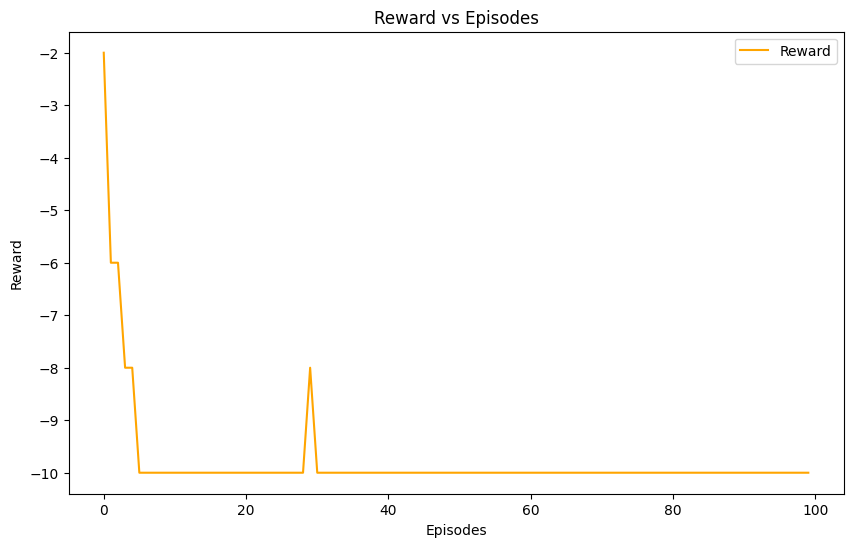

In [31]:
# Reward vs Episodes
plt.figure(figsize=(10, 6))
plt.plot(range(len(rewards)), rewards, color='orange', label='Reward')
plt.title("Reward vs Episodes")
plt.xlabel("Episodes")
plt.ylabel("Reward")
plt.legend()
plt.show()

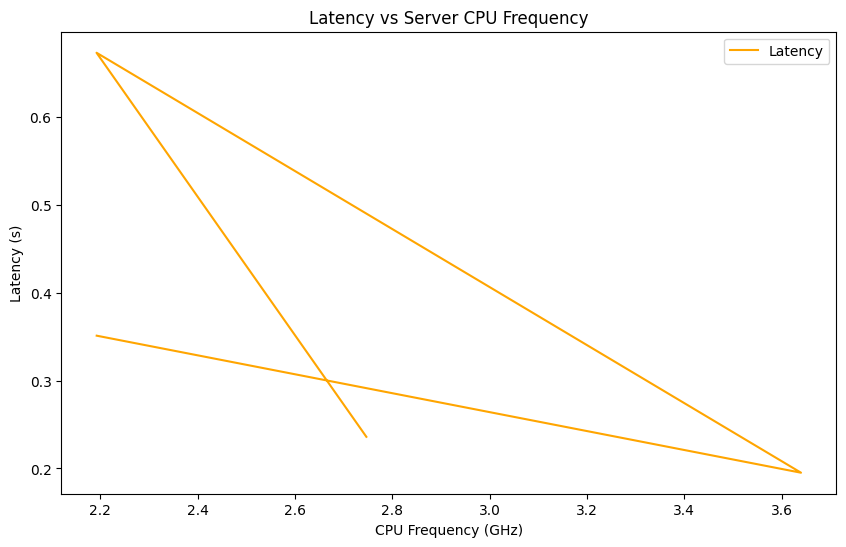

In [32]:
# Latency vs Server CPU Frequency
server_cpu_frequencies = [random.uniform(2, 4) for _ in edge_servers]  # Example CPU frequencies
latencies = [random.uniform(0.1, 1.0) for _ in edge_servers]  # Simulated latency values

plt.figure(figsize=(10, 6))
plt.plot(server_cpu_frequencies, latencies, color='orange', label='Latency')
plt.title("Latency vs Server CPU Frequency")
plt.xlabel("CPU Frequency (GHz)")
plt.ylabel("Latency (s)")
plt.legend()
plt.show()

In [33]:
def plot_task_allocation(users, edge_servers):
    print("Task allocation visualization placeholder.")
    for user in users:
        allocated_server_id = user.assigned_server.server_id if user.assigned_server else None
        print(f"User {user.user_id} allocated to server {allocated_server_id}")

users = [User(user_id=i, task_size=random.randint(1, 10)) for i in range(10)]

edge_servers = [EdgeServer(server_id=i, capacity=random.randint(15, 30)) for i in range(4)]

for user in users:
    for server in edge_servers:
        if server.allocate_task(user.get_task_size()):
            user.assigned_server = server  # Assign user to server
            break  # Move to the next user

plot_task_allocation(users, edge_servers) # Call the function after allocation

Task allocation visualization placeholder.
User 0 allocated to server 0
User 1 allocated to server 0
User 2 allocated to server 0
User 3 allocated to server 0
User 4 allocated to server 0
User 5 allocated to server 0
User 6 allocated to server 0
User 7 allocated to server 0
User 8 allocated to server 0
User 9 allocated to server 1
